# Introduction
![](https://zeynepstefan.com/wp-content/uploads/2018/04/creditrisk.jpg)

## Aim:

Making risk prediction based on given features.

## Context:

The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

## Content:
1. [Data Understanding](#1)
    * [Load and Check Data](#2)
    * [Variable Description](#3)
    * [Data Visualization](#4)
1. [Data Preprocessing](#5)                          
1. [Modeling](#6)
    * [KNN Model](#7)
    * [SVC Model](#8)
    * [XGBoost Model](#9)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling 
import seaborn as sns # visualization
import matplotlib.pyplot as plt # visualization
from sklearn.preprocessing import LabelEncoder # label encoding
from sklearn.model_selection import train_test_split # train, test split
from sklearn.preprocessing import StandardScaler # normalization
from sklearn.neighbors import KNeighborsClassifier # KNN model
from sklearn.svm import SVC # SVC model
from xgboost import XGBClassifier # XGBoost model
from sklearn.model_selection import GridSearchCV, cross_val_score # Gridsearch 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve# results

import warnings # ignore warning
warnings.filterwarnings("ignore")

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/german-credit-data-with-risk/german_credit_data.csv


<a id="1"></a>
# 1) Data Understanding

<a id="2"></a>
## Load and Check Data

In [2]:
# reading and copying data
data = pd.read_csv("/kaggle/input/german-credit-data-with-risk/german_credit_data.csv", index_col = "Unnamed: 0")
df = data.copy()

* overview of data

In [3]:
# overview of data
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


<a id="3"></a>
## Variable Description

Meaning of the Values:

1. Age: Age of the person applying for the credit.
1. Sex: Gender of the person applying for the credit.
1. Job: 0,1,2,3 The values specified for the job in the form of 0,1,2,3.
1. Housing: own, rent or free.
1. Saving accounts: the amount of money in the person's bank account.
1. Checking account: cheque account.
1. Credit amount: Credit amount.
1. Duration: Time given for credit payment.
1. Purpose: Goal of credit application.
1. Risk: Credit application positive or negative.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


Summary of the Columns and Rows:

* int64(4): Age, Job, Credit amount, Duration
* object(6): Sex, Housing, Saving accounts, Checking account, Purpose, Risk
* row number: 1000
* column number: 10

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


Summary of Statistics of Numerical Values:

* Age: max 75.0, min 19.0, mean 35.546
* Job: max 3.0, min 0.0, mean 1.904
* Credit amount: max 18424.0, min 250.0, mean 3271.258
* Duration: max 72.0, min 4.0, mean 20.903

In [6]:
columns = ["Age","Sex","Job","Housing","Saving accounts","Checking account","Credit amount","Duration","Purpose","Risk"]

def unique_value(data_set, column_name):
    return data_set[column_name].nunique()

print("Number of the Unique Values:\n",unique_value(df, columns))    

Number of the Unique Values:
 Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


Number of the Unique Values:

* Age(53):
* Sex(2): (male, female)
* Job(4): (0, 1, 2, 3)
* Housing(3): (own, free, rent)
* Saving accounts(4): (little, moderate, quite rich, rich)
* Checking account(3): (little, moderate, rich)
* Credit amount(921):
* Duration(33):
* Purpose(8): (radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others)
* Risk(2): (bad, good)

In [7]:
# Missing Value Table
def missing_value_table(df):
    missing_value = df.isna().sum().sort_values(ascending=False)
    missing_value_percent = 100 * df.isna().sum()//len(df)
    missing_value_table = pd.concat([missing_value, missing_value_percent], axis=1)
    missing_value_table_return = missing_value_table.rename(columns = {0 : 'Missing Values', 1 : '% Value'})
    cm = sns.light_palette("lightgreen", as_cmap=True)
    missing_value_table_return = missing_value_table_return.style.background_gradient(cmap=cm)
    return missing_value_table_return
  
missing_value_table(df)

,Missing Values,% Value
Checking account,394,39
Saving accounts,183,18
Risk,0,0
Purpose,0,0
Duration,0,0
Credit amount,0,0
Housing,0,0
Job,0,0
Sex,0,0
Age,0,0


Number of Missing Values:

* Checking account: number of missing value 394, percent of missing value 39
* Saving accounts: number of missing value 183, percent of missing value18

In [8]:
date_int = ["Purpose", 'Sex']
cm = sns.light_palette("lightgreen", as_cmap=True)
pd.crosstab(df[date_int[0]], df[date_int[1]]).style.background_gradient(cmap = cm)

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


Sex and Purpose:

* Women(94) and Men(243) applied for credit mostly for cars.
* Women(3) applied for credit least for vacation/others.
* Men(6) applied for credit least for domestic appliances.

<a id="4"></a>
## Data Visualization

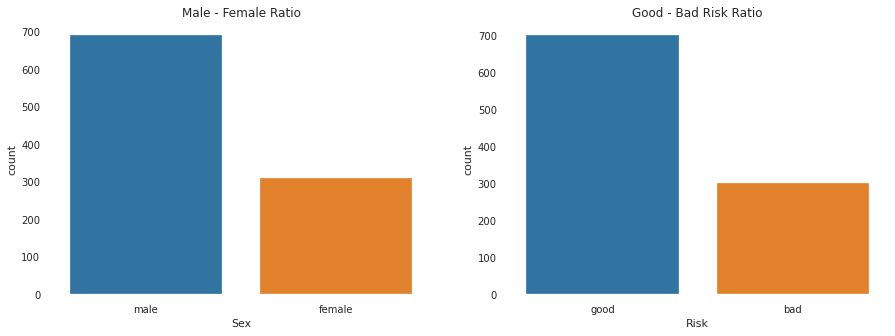

In [9]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.countplot(df['Sex'], ax=ax[0]).set_title('Male - Female Ratio');
sns.countplot(df.Risk, ax=ax[1]).set_title('Good - Bad Risk Ratio');

* Looking at the graphics, the rate of males in this data set is higher than the rate of females.
* Looking at the graphics, the rate of good risk in this data set is higher than the rate of bad risk.

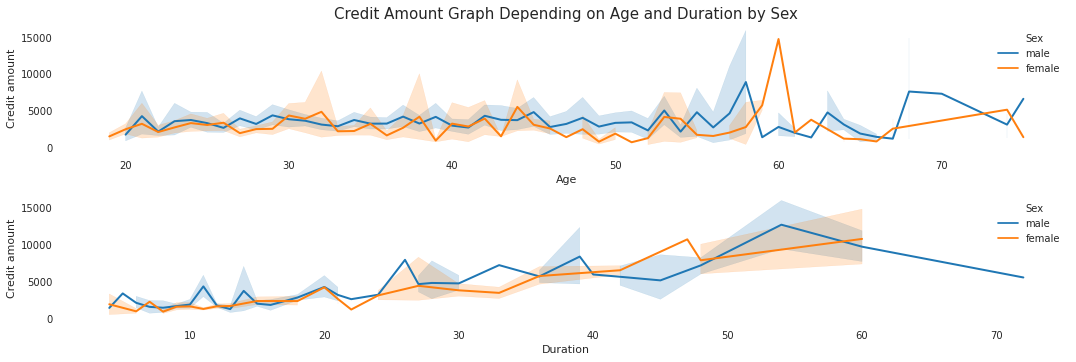

In [10]:
fig, ax = plt.subplots(2,1,figsize=(15,5))
plt.tight_layout(2)
sns.lineplot(data=df, x='Age', y='Credit amount', hue='Sex', lw=2, ax=ax[0]).set_title("Credit Amount Graph Depending on Age and Duration by Sex", fontsize=15);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Sex', lw=2, ax=ax[1]);

* Looking at the chart, the highest credit amount was reached at the age of 60 and around.
* Looking at the graph, the highest loan amounts between 50-60 duration have been reached.

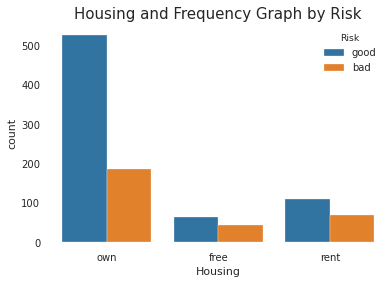

In [11]:
sns.countplot(x="Housing", hue="Risk", data=df).set_title("Housing and Frequency Graph by Risk", fontsize=15);
plt.show()

* The risk rates are higher in the own, free and rent categories then bad risk.
* Owners of their own homes are the people who apply for a loan the most.

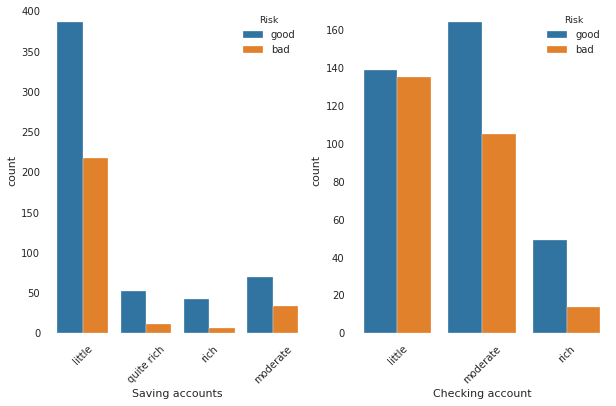

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
sns.countplot(x="Saving accounts", hue="Risk", data=df, ax=ax1);
sns.countplot(x="Checking account", hue="Risk", data=df, ax=ax2);
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
fig.show()

* At first scan, it is thought that the rich people will get more credit, but it does not seem to be clearly on the graphics.

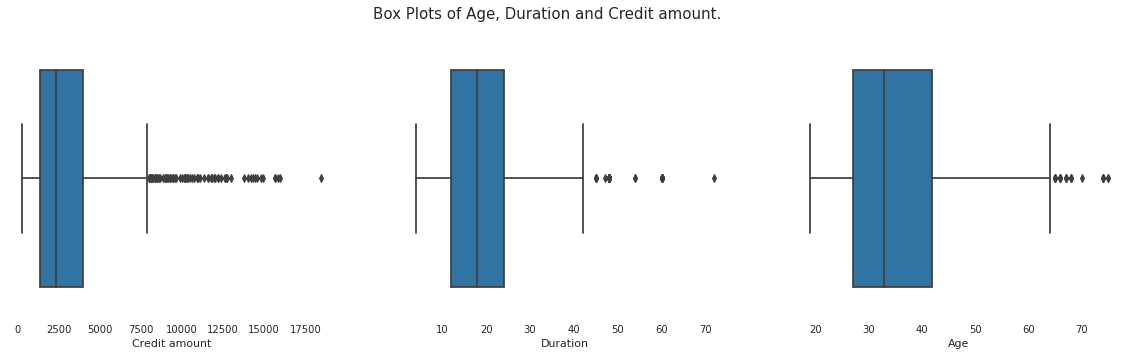

In [13]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('Box Plots of Age, Duration and Credit amount.',fontsize = 15)
sns.boxplot(df['Credit amount'], ax=ax[0]);
sns.boxplot(df['Duration'], ax=ax[1]);
sns.boxplot(df['Age'], ax=ax[2]);
plt.show()

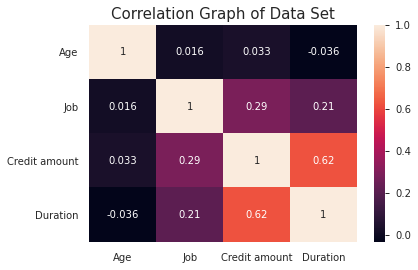

In [14]:
cor = df.corr()
sns.heatmap(cor, annot=True).set_title("Correlation Graph of Data Set",fontsize=15);
plt.show()

* There is a correlation between Credit amount and Duration(0.62).

<a id="5"></a>
# 2) Data Preprocessing

In [15]:
# Label Encoding
columns_label = ["Sex","Risk"]
labelencoder = LabelEncoder()
for i in columns_label:
    df[i] = labelencoder.fit_transform(df[i])

* Label encoding

In [16]:
Cat_Age = []
for i in df["Age"]:
    if i<25:
        Cat_Age.append("0-25")
    elif (i>=25) and (i<30):
        Cat_Age.append("25-30")
    elif (i>=30) and (i<35):
        Cat_Age.append("30-35")
    elif (i>=35) and (i<40):
        Cat_Age.append("35-40")
    elif (i>=40) and (i<50):
        Cat_Age.append("40-50")
    elif (i>=50) and (i<76):
        Cat_Age.append("50-75")
        
df["Cat Age"] = Cat_Age        

* converting age to category.

In [17]:
# Get Dummies
columns_dummy = ['Housing','Saving accounts','Checking account',"Purpose","Cat Age"]
for i in columns_dummy:
    df = pd.concat([df, pd.get_dummies(df[i])], axis=1)

* Used get dummies method for some columns.

In [18]:
df.drop(['Housing','Saving accounts','Checking account',"Purpose","Age","Cat Age"], axis = 1, inplace=True)

* drop unnecessary columns.

!!! missing values were not filled or droped because when filled or droped, the accuracy value was decreasing. 

<a id="6"></a>
# 3) Modeling

In [19]:
y = df.Risk
X = df.drop("Risk", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

* Separated data as train and test.

In [20]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

* Applied standart scaling.

<a id="7"></a>
## KNN(K-Nearest Neighbors) Model

In [21]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test) 
print('With KNN (K=3) accuracy is: ',knn_model.score(X_test,y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

With KNN (K=3) accuracy is:  0.69
[[ 20  39]
 [ 23 118]]
              precision    recall  f1-score   support

           0       0.47      0.34      0.39        59
           1       0.75      0.84      0.79       141

    accuracy                           0.69       200
   macro avg       0.61      0.59      0.59       200
weighted avg       0.67      0.69      0.67       200



* Accuracy is 0.69 (K = 3) 

* Checking max. accuracy with graph.

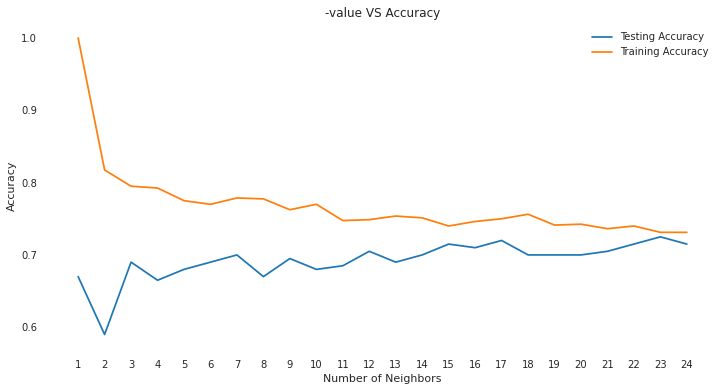

Best accuracy is 0.725 with K = 23


In [22]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn_model = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn_model.fit(X_train,y_train)
    #train accuracy
    train_accuracy.append(knn_model.score(X_train, y_train))
    # test accuracy
    test_accuracy.append(knn_model.score(X_test, y_test))

# Plot
plt.figure(figsize=[12,6])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('-value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

In [23]:
knn_model = KNeighborsClassifier(n_neighbors = 23)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test) 
print('With KNN (K=23) accuracy is: ',knn_model.score(X_test,y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

With KNN (K=23) accuracy is:  0.725
[[ 11  48]
 [  7 134]]
              precision    recall  f1-score   support

           0       0.61      0.19      0.29        59
           1       0.74      0.95      0.83       141

    accuracy                           0.73       200
   macro avg       0.67      0.57      0.56       200
weighted avg       0.70      0.72      0.67       200



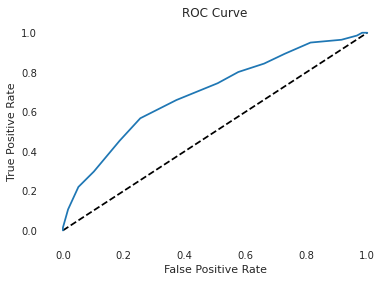

In [24]:
#Predicting proba
y_pred_prob = knn_model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

* Max accuracy is 0.725(K=23)

In [25]:
#Predicting proba
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

NameError: name 'model' is not defined

<a id="8"></a>
## SVC(Support Vector Classification) Model

In [26]:
svc_model = SVC(kernel = "rbf").fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Accuracy Score: 0.745


* Before Tuning accuracy score is 0.745.  

In [27]:
svc_params ={"C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
             ,"gamma": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}
svc = SVC()
svc_cv_model = GridSearchCV(svc, svc_params, cv = 10, n_jobs = -1, verbose = 2)
svc_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   13.4s finished


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50,
                                   100]},
             verbose=2)

In [28]:
print("Best Parameters: "+ str(svc_cv_model.best_params_))

Best Parameters: {'C': 10, 'gamma': 0.01}


In [29]:
svc_tuned = SVC(C = 10, gamma = 0.01).fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Accuracy Score: 0.745


* After Tuning accuracy score same with before tuning so, 0.745.

<a id="9"></a>
## XGBoost Model

In [30]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(accuracy_score(y_pred_xgb, y_test))

0.735


* Before tuning accuracy score is 0.735.

In [31]:
xgb_params = {"n_estimators": [100, 500, 1000, 2000],
             "subsample": [0.6, 0.8, 1.0],
             "max_depth": [3, 4, 5, 6],
             "learning_rate": [0.1, 0.01, 0.02, 0.05],
             "min_samples_split": [2,5,10]}
xgb = XGBClassifier()
xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1, verbose = 2)
xgb_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 29.7min


[15:07:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 36.0min finished


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_job...,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [32]:
print("Best Parameters: "+ str(xgb_cv_model.best_params_))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}


In [33]:
xgb = XGBClassifier(learning_rate = 0.05, max_depth = 5, min_samples_split=2,n_estimators=100,subsample=0.8 )
xgb_tuned = xgb.fit(X_train,y_train)
y_pred = xgb_tuned.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))

[15:07:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy Score: 0.79


* After tuning accuracy score is 0.79.